<a href="https://colab.research.google.com/github/jemalmgr/AH2179/blob/main/Hand_In_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AH2179 Hand-In Assignment 4
## Use the neural network model for bus arrival delay prediction
By Jennifer Malmgren

### Setup

In [1]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [2]:
# Imports

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Get the dataset

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7data.csv'
df = pd.read_csv(url)
df

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:06,10261,44417,3,69,0,82,33,99.925373
1,01/05/2022 07:20,10261,45544,3,35,0,82,52,100.191176
2,01/05/2022 07:35,10261,44410,3,7,0,82,10,99.681159
3,01/05/2022 07:51,10261,41724,3,74,15,82,27,99.385714
4,01/05/2022 20:16,10261,45544,3,-3,0,109,17,116.298507
...,...,...,...,...,...,...,...,...,...
4957,30/05/2022 22:02,10261,41734,4,32,0,120,28,161.900000
4958,31/05/2022 21:32,10261,41375,4,16,0,120,6,157.607692
4959,31/05/2022 21:43,10261,41373,4,69,0,120,59,157.396947
4960,31/05/2022 21:53,10261,41367,4,74,0,120,87,157.189394


### Data preparation

In [4]:
# Keep only the interesting data

df = df.drop(['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id'], axis=1)
df

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,69,0,82,33,99.925373
1,35,0,82,52,100.191176
2,7,0,82,10,99.681159
3,74,15,82,27,99.385714
4,-3,0,109,17,116.298507
...,...,...,...,...,...
4957,32,0,120,28,161.900000
4958,16,0,120,6,157.607692
4959,69,0,120,59,157.396947
4960,74,0,120,87,157.189394


In [5]:
# Create a train/test split

x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((3969, 4), (3969,)), ((993, 4), (993,)))

### Network construction

In [6]:
# Find optimal nn construction using keras tuner
# Recommended resources:
# https://keras.io/keras_tuner/
# https://www.youtube.com/watch?v=6Nf1x7qThR8

def build_model(hp):

  hp_l1_units = hp.Int('l1_units', min_value=16, max_value=64, step=16)
  hp_l1_droprate = hp.Choice('l1_droprate', values=[0.0, 0.2, 0.5])
  hp_l2_units = hp.Int('l2_units', min_value=8, max_value=32, step=8)
  hp_l2_droprate = hp.Choice('l2_droprate', values=[0.0, 0.2, 0.5])
  hp_activation = hp.Choice('activation', values=['relu', 'sigmoid'])
  hp_lr = hp.Choice('lr', values=[0.01, 0.001])

  model = Sequential()
  model.add(Dense(hp_l1_units, activation=hp_activation, input_dim=4))
  model.add(Dropout(hp_l1_droprate))
  model.add(Dense(hp_l2_units, activation=hp_activation))
  model.add(Dropout(hp_l2_droprate))
  model.add(Dense(1))
  model.compile(optimizer=Adam(hp_lr), loss='mae', metrics=['mae'])

  return model

tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     max_epochs=50,
                     factor=3,
                     seed=42,
                     directory='ah2179',
                     project_name='hand_in_4')

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Trial 90 Complete [00h 00m 10s]
val_mae: 26.50657844543457

Best val_mae So Far: 25.224483489990234
Total elapsed time: 00h 11m 11s


In [7]:
# Check the best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

l1_units: 64
l1_droprate: 0.0
l2_units: 16
l2_droprate: 0.2
activation: relu
lr: 0.01
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047


In [8]:
# Make the best model

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 42.5954 - mae: 42.5954 - val_loss: 28.5072 - val_mae: 28.5072 - learning_rate: 0.0100
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.2670 - mae: 33.2670 - val_loss: 27.3267 - val_mae: 27.3267 - learning_rate: 0.0100
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.5319 - mae: 34.5319 - val_loss: 26.2712 - val_mae: 26.2712 - learning_rate: 0.0100
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.6178 - mae: 33.6178 - val_loss: 28.6279 - val_mae: 28.6279 - learning_rate: 0.0100
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1506 - mae: 33.1506 - val_loss: 29.1632 - val_mae: 29.1632 - learning_rate: 0.0100
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.6929 - mae: 32.6929 - val_loss: 27.1001 - val_mae: 27.1001 - learning_rate: 0.0100
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.4790 - mae: 32.4790 - val_loss: 26.2406 - val_mae: 26.2406 - learning_r

In [9]:
# Check the history

pd.DataFrame(history.history)

,loss,mae,val_loss,val_mae,learning_rate
0,37.633831,37.633831,28.507177,28.507177,0.0100
1,33.919041,33.919041,27.326710,27.326710,0.0100
2,34.289787,34.289787,26.271189,26.271189,0.0100
3,33.341145,33.341145,28.627920,28.627920,0.0100
4,33.076561,33.076561,29.163244,29.163244,0.0100
5,32.725700,32.725700,27.100119,27.100119,0.0100
6,33.155552,33.155552,26.240559,26.240559,0.0050
7,32.283764,32.283764,25.396894,25.396894,0.0050
8,32.954842,32.954842,25.873419,25.873419,0.0050
9,32.657295,32.657295,25.761232,25.761232,0.0050


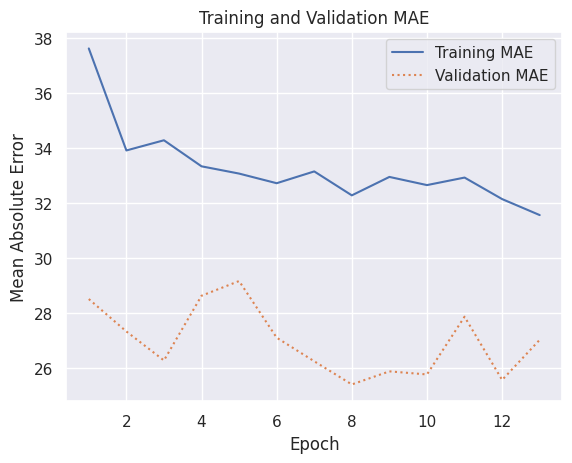

In [10]:
# Plot the training and validation MAE

sns.set()

err = history.history['mae']
val_err = history.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()

In [11]:
# Evaluate the best model

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('--------------------------------------This is result of the best model---------------------------------------------')
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
--------------------------------------This is result of the best model---------------------------------------------
Mean Absolute Error: 27.983376782346227
Mean Squared Error: 1340.917201724423
R-squared: 0.9120179414749146
